In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from collections import Counter
import re
from pymorphy3 import MorphAnalyzer
from collections import defaultdict
import nltk
from nltk.corpus import stopwords

In [32]:
nltk.download('stopwords')
stopwords_ru = set(stopwords.words('russian'))
patterns = "[«»A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
morph = MorphAnalyzer()
path = r"/Users/wardonne/Desktop/Lab_python/PP_3_Lab/annotation1.csv"

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


In [33]:
"""
Чтение данных из CSV-файла и преобразование их в DataFrame.

Args:
- path (str): Путь к CSV-файлу.

Returns:
pd.core.frame.DataFrame: DataFrame с колонками 'review' и 'rating'.
"""
df_csv = pd.read_csv(path)
texts = []
for absolute_path, rating in zip(df_csv['absolute_path'], df_csv['rating']):
    with open(absolute_path, 'r', encoding='utf-8') as file:
        text = file.read()
        texts.append((text, rating))

df = pd.DataFrame(texts, columns=['review', 'rating'])

In [34]:
print(df)

                                                review  rating
0    Марья Моревна. Комикс. Том 1\nИтак, пришла ко ...       1
1    Академия адептов, колдунов и магов. Испытание ...       1
2    Арена страсти\nНе знаю, каковы другие книги эт...       1
3    Тачдаун\nАхахаха, знаете, если мне не нравится...       1
4    Ген хищника\nСейчас модно писать «5 причин про...       1
..                                                 ...     ...
495  Первые чувства. Искры снега\nНики Сью "Искры с...       5
496  Именинница\nВремя-одно из препятствий, которое...       5
497  Принц льда и крови\nДанная книга зацепила свое...       5
498  Любовь на десерт\nКогда у тебя кипит, и ты дол...       5
499  Братья и сестры. Как помочь вашим детям жить д...       5

[500 rows x 2 columns]


In [35]:
"""
Удаление строк с отсутствующими значениями.

Args:
- df (pd.core.frame.DataFrame): Исходный DataFrame.

Returns:
pd.core.frame.DataFrame: DataFrame без отсутствующих значений.
"""
print(df.isnull().sum())
df.dropna()

review    0
rating    0
dtype: int64


In [36]:
"""
Добавление колонки 'count_word' с количеством слов в каждом отзыве.

Args:
- df (pd.core.frame.DataFrame): Исходный DataFrame.

Returns:
pd.core.frame.DataFrame: DataFrame с новой колонкой 'count_word'.
"""
df['count_word'] = df['review'].apply(lambda word: len(word.split()))
print(df.head())

                                              review  rating  count_word
0  Марья Моревна. Комикс. Том 1\nИтак, пришла ко ...       1         603
1  Академия адептов, колдунов и магов. Испытание ...       1         266
2  Арена страсти\nНе знаю, каковы другие книги эт...       1          93
3  Тачдаун\nАхахаха, знаете, если мне не нравится...       1         371
4  Ген хищника\nСейчас модно писать «5 причин про...       1         378


In [37]:
print(df.describe())

          rating   count_word
count  500.00000   500.000000
mean     3.00000   252.214000
std      1.41563   237.136204
min      1.00000     4.000000
25%      2.00000   116.000000
50%      3.00000   192.500000
75%      4.00000   310.000000
max      5.00000  2141.000000


In [38]:
def filter_by_words(df: pd.core.frame.DataFrame, count_words: int) -> pd.core.frame.DataFrame:
    """
    Фильтрация DataFrame по количеству слов в отзыве.

    Args:
    - df (pd.core.frame.DataFrame): Исходный DataFrame.
    - count_words (int): Пороговое значение количества слов.

    Returns:
    pd.core.frame.DataFrame: Отфильтрованный DataFrame.
    """
    return df[df.count_word >= count_words]

In [39]:
def filter_by_rating(df: pd.core.frame.DataFrame, count_rating: int) -> pd.core.frame.DataFrame:
    """
    Фильтрация DataFrame по рейтингу.

    Args:
    - df (pd.core.frame.DataFrame): Исходный DataFrame.
    - count_rating (int): Значение рейтинга для фильтрации.

    Returns:
    pd.core.frame.DataFrame: Отфильтрованный DataFrame.
    """
    return df[df.rating == count_rating]

print(filter_by_rating(df, 1))

                                               review  rating  count_word
0   Марья Моревна. Комикс. Том 1\nИтак, пришла ко ...       1         603
1   Академия адептов, колдунов и магов. Испытание ...       1         266
2   Арена страсти\nНе знаю, каковы другие книги эт...       1          93
3   Тачдаун\nАхахаха, знаете, если мне не нравится...       1         371
4   Ген хищника\nСейчас модно писать «5 причин про...       1         378
..                                                ...     ...         ...
95  Икигай. Японские секреты долгой и счастливой ж...       1          45
96  Марта и полтора убийства\nна редкость нелепая ...       1          54
97  Обнимашки с мурозданием. Теплые сказки о счаст...       1          72
98  Девушка из Уидоу-Хиллз\nсерьёзно? люди 20 лет ...       1          78
99  Карма\nИз любопытства купила эту книгу хваленн...       1         189

[100 rows x 3 columns]


In [40]:
a = df.groupby('rating').agg({'count_word': ['min', 'max', 'mean']})
print(a)

       count_word              
              min   max    mean
rating                         
1              10   820  218.23
2               8   832  212.23
3              39  2141  270.98
4               4  1621  267.96
5              29  1871  291.67


In [41]:
def lemmatize(review: str) -> List[str]:
    """
    Лемматизация текста.

    Args:
    - review (str): Исходный текст.

    Returns:
    List[str]: Список лемм.
    """
    review = re.sub(patterns, ' ', review)
    tokens = review.lower().split()
    preprocessed_text = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form
        if lemma not in stopwords_ru:
            preprocessed_text.append(lemma)
    return preprocessed_text

def most_popular_words(df: pd.core.frame.DataFrame, rating: int) -> List[tuple[str, int]]:
    """
    Определение самых популярных слов для заданного рейтинга.

    Args:
    - df (pd.core.frame.DataFrame): Исходный DataFrame.
    - rating (int): Значение рейтинга.

    Returns:
    List[tuple[str, int]]: Список кортежей (слово, частота).
    """
    data = df[df['rating'] == rating]['review'].apply(lemmatize)
    words = Counter()
    for txt in data:
        words.update(txt)
    return words.most_common(10)

In [42]:
def graph_build(hist_list: List[tuple[str, int]]) -> None:
    """
    Построение гистограммы для списка слов.

    Args:
    - hist_list (List[tuple[str, int]]): Список кортежей (слово, частота).

    Returns:
    None
    """
    words = []
    count = []
    for i in range(len(hist_list)):
        words.append(hist_list[i][0])
        count.append(hist_list[i][1])

    fig, ax = plt.subplots()

    ax.bar(words, count)
    ax.set_ylabel('Количество')
    ax.set_title('Гистограмма самых популярных слов')
    plt.show()

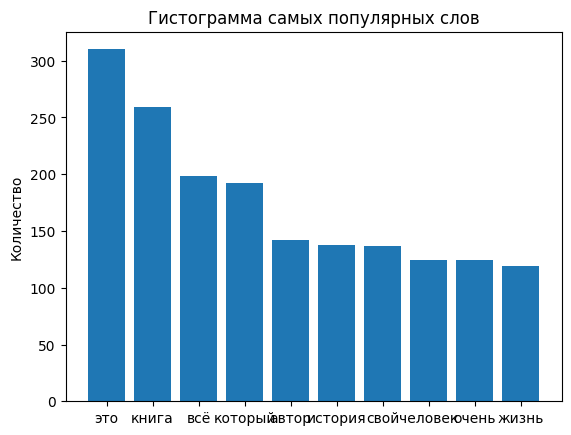

In [43]:
graph_build(most_popular_words(df, 5))